In [1]:
import pickle as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

In [43]:
with open("saved/sportsandoutdoors/LightGCN/e0.1/LightGCN-Sep-29-2023_23-16-57.pkl", "rb") as f:
    recommendation_list = pl.load(f)
for v in recommendation_list.values():
    print(v)
print(len(set([tuple(sorted(recs)) for _, recs in recommendation_list.items()])))

['82507' '15786' '44692' '24447' '23915' '17829' '59188' '5955' '90534'
 '575']
['82507' '15786' '44692' '13978' '15126' '23915' '575' '8596' '24447'
 '28052']
['82507' '15786' '44692' '13978' '23915' '8596' '28052' '27399' '575'
 '15126']
['82507' '15786' '44692' '15126' '13978' '8596' '23915' '90534' '5955'
 '85966']
['82507' '15786' '15126' '44692' '13978' '8596' '5955' '24447' '23915'
 '90534']
['82507' '15786' '44692' '13978' '24447' '23915' '85966' '5955' '15126'
 '90534']
['82507' '15786' '44692' '5955' '23915' '15126' '13978' '6216' '59188'
 '90534']
['82507' '15786' '44692' '6216' '575' '13978' '15126' '23915' '42406'
 '5955']
['82507' '15786' '44692' '13978' '6216' '5955' '8596' '15126' '85966'
 '24447']
['82507' '15786' '44692' '24447' '13978' '5955' '6216' '23915' '85966'
 '15126']
['82507' '15786' '44692' '6216' '15126' '13978' '90534' '24447' '5955'
 '64124']
['82507' '15786' '44692' '85966' '24447' '23915' '9377' '13978' '15126'
 '5955']
['82507' '15786' '44692' '23915' 

In [2]:
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

def results_per_group(results, group=None):
    if group is None:
        return np.mean([np.mean([results_f[uid] for uid in results_f]) for idx, results_f in enumerate(results)])
    else:
        return np.mean([np.mean([results_f[uid] for uid in group if uid in results_f]) for idx, results_f in enumerate(results)])

def recgap(x, y):
    return np.abs(np.array(x) - np.array(y))

def _gap(recommendation_list, item_popularity, user_profile_popularity):
    arp = np.mean([item_popularity.loc[str(iid)] for iid in recommendation_list])
    return (arp - user_profile_popularity) / user_profile_popularity

def _compute_gap(dirpath, item_popularity, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    gaps = []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            gap = dict()
            for uid, recs in recommendation_list.items():
                if uid not in impacted_users[idx]:
                    continue
                gap[uid] = _gap(recommendation_list=recs, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity[uid])
            gaps.append(gap)
        else:
            gap = dict()
            for uid, recs in recommendation_list.items():
                gap[uid] = _gap(recommendation_list=recs, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity[uid])
            gaps.append(gap)

    return gaps

def sort_files(path):
    base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            files.append(file)

    LEN_PREFIX = len(model_name)+1
    LEN_SUFFIX = len(".pkl")
    timestamps = [filename[LEN_PREFIX:-LEN_SUFFIX] for filename in files]
    sorted_timestamps = sorted(timestamps)
    sorted_files = [model_name + "-" + timestamp + ".pkl" for timestamp in sorted_timestamps]

    return sorted_files

def _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=None):
    cut = int(len(item_popularity) * 0.8)
    tail_items = set(item_popularity.sort_values(ascending=True).iloc[:cut].index.tolist())

    recall, ndcg, arp, aft = dict(), dict(), dict(), dict()
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        recall[uid] = len(groundtruth.loc[uid].intersection([str(iid) for iid in recs])) / len(groundtruth.loc[uid])

        dcg = 0.0
        idcg = 0.0
        for pos in range(1, len(recs)+1):
            item_at_i = str(recs[pos-1])
            rel_i = item_at_i in groundtruth.loc[uid]
            dcg += rel_i / np.log2(pos + 1)
            idcg += 1 / np.log2(pos + 1)
        ndcg[uid] = dcg / idcg
        arp[uid] = np.mean([item_popularity.loc[str(item_id)] for item_id in recs])
        aft[uid] = len(tail_items.intersection([str(iid) for iid in recs])) / len(recs)


    return recall, ndcg, arp, aft


def _analyze_recommendations(dirpath, item_popularity, groundtruth, impacted_users=None):
    files = sort_files(dirpath)
    recalls, ndcgs, arps, afts = [], [], [], []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=impacted_users[idx])
        else:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth)

        recalls.append(recall)
        ndcgs.append(ndcg)
        arps.append(arp)
        afts.append(aft)

    return recalls, ndcgs, arps, afts

def _get_impacted_users(dirpath_nodp, dirpath_dp):
    files_nodp = sort_files(dirpath_nodp)
    files_dp = sort_files(dirpath_dp)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_nodp, file_dp in zip(files_nodp, files_dp):
        with open(dirpath_nodp + "/" + file_nodp, "rb") as f:
            recommendation_list_nodp = pl.load(f)

        with open(dirpath_dp + "/" + file_dp, "rb") as f:
            recommendation_list_dp = pl.load(f)

        impacted_users_f, dist_f = [], []
        for uid, recs_dp in recommendation_list_dp.items():
            recs_nodp = recommendation_list_nodp[uid]

            dist = jaccard_distance(recs_nodp, recs_dp)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_dp))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)




In [3]:
def analyze(dataset_name, model_name, groundtruth, item_popularity):
    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp

    print("No DP: %.4f (recall), %.4f (ndcg), %.4f (arp), %.4f (aft)" % (results_per_group(recall_nodp), results_per_group(ndcg_nodp), results_per_group(arp_nodp), results_per_group(aft_nodp)))


    delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
    percentage_impacted_users, average_jaccard_distance = [], []
    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
    #for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]:
        users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))

        results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=users)
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_eps

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(len(users)):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            """for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid]))
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid]))
                delta_arp_eps_f.append((arp_eps[file_idx][uid]))
                delta_aft_eps_f.append((aft_eps[file_idx][uid]))
            delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(np.nanmean(delta_aft_eps_f))"""
            for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                delta_arp_eps_f.append((arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                delta_aft_eps_f.append((aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(100 * np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(100 * np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(100 * np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))

        delta_recall.append(np.mean(delta_recall_eps))
        delta_ndcg.append(np.mean(delta_ndcg_eps))
        delta_arp.append(np.mean(delta_arp_eps))
        delta_aft.append(np.mean(delta_aft_eps))

        percentage_impacted_users.append(100 * frac_impacted)
        average_jaccard_distance.append(jacc)

        print("eps: %f -> %f%% (recall), %f%% (ndcg), %f%% (arp), %f%% (aft), %f (No. Users), %f (Jacc)" % (
            eps, delta_recall[-1], delta_ndcg[-1], delta_arp[-1], delta_aft[-1], percentage_impacted_users[-1], average_jaccard_distance[-1]))
    print()
    return delta_recall, delta_ndcg, delta_arp, delta_aft, percentage_impacted_users, average_jaccard_distance

In [44]:
dataset_name = "sportsandoutdoors"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

In [45]:
delta_recall, delta_ndcg, delta_arp, delta_aft = dict(), dict(), dict(), dict()
no_users, jacc_dist = dict(), dict()

"""recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["BPR"] = recall
delta_ndcg["BPR"] = ndcg
delta_arp["BPR"] = arp
delta_aft["BPR"] = aft
no_users["BPR"] = impacted_users
jacc_dist["BPR"] = jacc"""

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["NeuMF"] = recall
delta_ndcg["NeuMF"] = ndcg
delta_arp["NeuMF"] = arp
delta_aft["NeuMF"] = aft
no_users["NeuMF"] = impacted_users
jacc_dist["NeuMF"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["LightGCN"] = recall
delta_ndcg["LightGCN"] = ndcg
delta_arp["LightGCN"] = arp
delta_aft["LightGCN"] = aft
no_users["LightGCN"] = impacted_users
jacc_dist["LightGCN"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["MultiVAE"] = recall
delta_ndcg["MultiVAE"] = ndcg
delta_arp["MultiVAE"] = arp
delta_aft["MultiVAE"] = aft
no_users["MultiVAE"] = impacted_users
jacc_dist["MultiVAE"] = jacc

No DP: 0.0063 (recall), 0.0038 (ndcg), 0.0197 (arp), 0.0000 (aft)


C:\Users\pmuellner\AppData\Local\Temp\ipykernel_22220\645581896.py:39: RuntimeWarning: Mean of empty slice
  delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))


eps: 10.000000 -> -26.196022% (recall), -20.603477% (ndcg), -2.345697% (arp), nan% (aft), 100.000000 (No. Users), 0.477191 (Jacc)
eps: 5.000000 -> -25.042904% (recall), -22.976692% (ndcg), -3.111249% (arp), nan% (aft), 100.000000 (No. Users), 0.489365 (Jacc)
eps: 4.000000 -> -22.753061% (recall), -17.872553% (ndcg), -1.915911% (arp), nan% (aft), 100.000000 (No. Users), 0.427234 (Jacc)
eps: 3.000000 -> -23.312563% (recall), -20.513833% (ndcg), -2.483498% (arp), nan% (aft), 100.000000 (No. Users), 0.440526 (Jacc)
eps: 2.000000 -> -19.427556% (recall), -13.791034% (ndcg), -2.877167% (arp), nan% (aft), 100.000000 (No. Users), 0.403811 (Jacc)
eps: 1.000000 -> -27.904092% (recall), -24.318056% (ndcg), -3.881091% (arp), nan% (aft), 100.000000 (No. Users), 0.490104 (Jacc)
eps: 0.500000 -> -20.095522% (recall), -14.824522% (ndcg), 0.271137% (arp), nan% (aft), 100.000000 (No. Users), 0.419436 (Jacc)
eps: 0.100000 -> -28.602242% (recall), -30.004176% (ndcg), -0.688647% (arp), nan% (aft), 100.0000

In [46]:
%matplotlib inline
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
#all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]

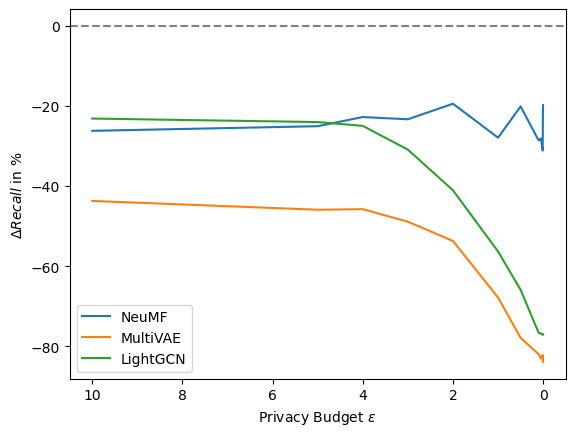

In [48]:
#plt.plot(all_eps, delta_recall["BPR"], label="BPR")
plt.plot(all_eps, delta_recall["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_recall["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_recall["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_recall["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta Recall$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

In [206]:
plt.plot(all_eps, delta_ndcg["BPR"], label="BPR")
plt.plot(all_eps, delta_ndcg["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_ndcg["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_ndcg["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_ndcg["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta nDCG$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

KeyError: 'BPR'

In [168]:
plt.plot(all_eps, delta_arp["BPR"], label="BPR")
plt.plot(all_eps, delta_arp["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_arp["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_arp["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_arp["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ ARP in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

In [169]:
plt.plot(all_eps, delta_aft["BPR"], label="BPR")
plt.plot(all_eps, delta_aft["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_aft["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_aft["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_aft["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ AFT in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

In [170]:
plt.plot(all_eps, no_users["BPR"], label="BPR")
plt.plot(all_eps, no_users["NeuMF"], label="NeuMF")
plt.plot(all_eps, no_users["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, no_users["LightGCN"], label="LightGCN")
#plt.plot(all_eps, no_users["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("No. Users in %")
plt.gca().invert_xaxis()
plt.legend()

In [171]:
plt.plot(all_eps, jacc_dist["BPR"], label="BPR")
plt.plot(all_eps, jacc_dist["NeuMF"], label="NeuMF")
plt.plot(all_eps, jacc_dist["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, jacc_dist["LightGCN"], label="LightGCN")
#plt.plot(all_eps, jacc_dist["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("Avg. Jaccard Distance")
plt.gca().invert_xaxis()
plt.legend()

In [50]:
def get_results(dataset_name, algos):
    test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
    test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    test_df["user_id"] = test_df["user_id"].astype(str)
    test_df["item_id"] = test_df["item_id"].astype(str)
    groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

    df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
    df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()


    recall, arp, aft = dict(), dict(), dict()
    for algo in algos:
        recall_a, _, arp_a, aft_a, _, _ = analyze(dataset_name=dataset_name, model_name=algo, groundtruth=groundtruth, item_popularity=item_popularity)
        recall[algo] = recall_a
        arp[algo] = arp_a
        aft[algo] = aft_a

    return recall, arp, aft

recall_ml1m, arp_ml1m, aft_ml1m = get_results(dataset_name="ml-1m", algos=["NeuMF", "LightGCN", "MultiVAE"])
recall_lfm, arp_lfm, aft_lfm = get_results(dataset_name="LFM-3k", algos=["NeuMF", "LightGCN", "MultiVAE"])
recall_amazon, arp_amazon, aft_amazon = get_results(dataset_name="sportsandoutdoors", algos=["NeuMF", "LightGCN", "MultiVAE"])

No DP: 0.0886 (recall), 0.1079 (ndcg), 0.2971 (arp), 0.0342 (aft)
eps: 10.000000 -> -4.528412% (recall), -1.399034% (ndcg), 1.986348% (arp), -13.164209% (aft), 98.637945 (No. Users), 0.455638 (Jacc)
eps: 5.000000 -> -5.141515% (recall), -1.398983% (ndcg), 3.497633% (arp), -23.298547% (aft), 98.671085 (No. Users), 0.459728 (Jacc)
eps: 4.000000 -> -5.035714% (recall), -0.764730% (ndcg), 9.542596% (arp), -38.699139% (aft), 98.942833 (No. Users), 0.479831 (Jacc)
eps: 3.000000 -> -7.540429% (recall), -3.393356% (ndcg), 6.153795% (arp), -28.662403% (aft), 99.400166 (No. Users), 0.513853 (Jacc)
eps: 2.000000 -> -10.617668% (recall), -5.307657% (ndcg), 18.557577% (arp), -65.746435% (aft), 99.758078 (No. Users), 0.586618 (Jacc)
eps: 1.000000 -> -16.627107% (recall), -9.334463% (ndcg), 36.185501% (arp), -79.405211% (aft), 99.946976 (No. Users), 0.699024 (Jacc)
eps: 0.500000 -> -20.603188% (recall), -12.883770% (ndcg), 57.667833% (arp), -95.845914% (aft), 99.976802 (No. Users), 0.769134 (Jacc)
ep

C:\Users\pmuellner\AppData\Local\Temp\ipykernel_22220\645581896.py:39: RuntimeWarning: Mean of empty slice
  delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))


eps: 10.000000 -> -26.196022% (recall), -20.603477% (ndcg), -2.345697% (arp), nan% (aft), 100.000000 (No. Users), 0.477191 (Jacc)
eps: 5.000000 -> -25.042904% (recall), -22.976692% (ndcg), -3.111249% (arp), nan% (aft), 100.000000 (No. Users), 0.489365 (Jacc)
eps: 4.000000 -> -22.753061% (recall), -17.872553% (ndcg), -1.915911% (arp), nan% (aft), 100.000000 (No. Users), 0.427234 (Jacc)
eps: 3.000000 -> -23.312563% (recall), -20.513833% (ndcg), -2.483498% (arp), nan% (aft), 100.000000 (No. Users), 0.440526 (Jacc)
eps: 2.000000 -> -19.427556% (recall), -13.791034% (ndcg), -2.877167% (arp), nan% (aft), 100.000000 (No. Users), 0.403811 (Jacc)
eps: 1.000000 -> -27.904092% (recall), -24.318056% (ndcg), -3.881091% (arp), nan% (aft), 100.000000 (No. Users), 0.490104 (Jacc)
eps: 0.500000 -> -20.095522% (recall), -14.824522% (ndcg), 0.271137% (arp), nan% (aft), 100.000000 (No. Users), 0.419436 (Jacc)
eps: 0.100000 -> -28.602242% (recall), -30.004176% (ndcg), -0.688647% (arp), nan% (aft), 100.0000

In [65]:
%matplotlib qt
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, recall_ml1m["NeuMF"][::-1][1:], color="C0")
ax1.plot(all_eps, recall_ml1m["LightGCN"][::-1][1:], color="C1")
ax1.plot(all_eps, recall_ml1m["MultiVAE"][::-1][1:], color="C2")
ax1.invert_xaxis()

ax2.plot(all_eps, recall_lfm["NeuMF"][::-1][1:], color="C0")
ax2.plot(all_eps, recall_lfm["LightGCN"][::-1][1:], color="C1")
ax2.plot(all_eps, recall_lfm["MultiVAE"][::-1][1:], color="C2")
ax2.invert_xaxis()

ax3.plot(all_eps, recall_amazon["NeuMF"][::-1][1:], color="C0")
ax3.plot(all_eps, recall_amazon["LightGCN"][::-1][1:], color="C1")
ax3.plot(all_eps, recall_amazon["MultiVAE"][::-1][1:], color="C2")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta Recall$ in %")
ax1.set_xlabel(r"Privacy Budget $\epsilon$")
ax2.set_xlabel(r"Privacy Budget $\epsilon$")
ax3.set_xlabel(r"Privacy Budget $\epsilon$")

ax1.set_title("ML 1M")
ax2.set_title("LastFM")
ax3.set_title("Amazon")

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="solid"))
lines.append(Line2D([0], [0], color="C1", linestyle="solid"))
lines.append(Line2D([0], [0], color="C2", linestyle="solid"))
labels = ["NeuMF", "LightGCN", "MultiVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])

In [76]:
%matplotlib qt

def f(x):
    #return np.log10(x)
    return x

all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, f(arp_ml1m["NeuMF"][::-1][1:]), color="C0")
ax1.plot(all_eps, f(arp_ml1m["LightGCN"][::-1][1:]), color="C1")
ax1.plot(all_eps, f(arp_ml1m["MultiVAE"][::-1][1:]), color="C2")
ax1.invert_xaxis()

ax2.plot(all_eps, f(arp_lfm["NeuMF"][::-1][1:]), color="C0")
ax2.plot(all_eps, f(arp_lfm["LightGCN"][::-1][1:]), color="C1")
ax2.plot(all_eps, f(arp_lfm["MultiVAE"][::-1][1:]), color="C2")
ax2.invert_xaxis()

ax3.plot(all_eps, f(arp_amazon["NeuMF"][::-1][1:]), color="C0")
ax3.plot(all_eps, f(arp_amazon["LightGCN"][::-1][1:]), color="C1")
ax3.plot(all_eps, f(arp_amazon["MultiVAE"][::-1][1:]), color="C2")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta ARP$ in %")
ax1.set_xlabel(r"Privacy Budget $\epsilon$")
ax2.set_xlabel(r"Privacy Budget $\epsilon$")
ax3.set_xlabel(r"Privacy Budget $\epsilon$")

ax1.set_title("ML 1M")
ax2.set_title("LastFM")
ax3.set_title("Amazon")

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="solid"))
lines.append(Line2D([0], [0], color="C1", linestyle="solid"))
lines.append(Line2D([0], [0], color="C2", linestyle="solid"))
labels = ["NeuMF", "LightGCN", "MultiVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])

In [74]:
%matplotlib qt

def f(x):
    return x

all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, f(aft_ml1m["NeuMF"][::-1][1:]), color="C0")
ax1.plot(all_eps, f(aft_ml1m["LightGCN"][::-1][1:]), color="C1")
ax1.plot(all_eps, f(aft_ml1m["MultiVAE"][::-1][1:]), color="C2")
ax1.invert_xaxis()

ax2.plot(all_eps, f(aft_lfm["NeuMF"][::-1][1:]), color="C0")
ax2.plot(all_eps, f(aft_lfm["LightGCN"][::-1][1:]), color="C1")
ax2.plot(all_eps, f(aft_lfm["MultiVAE"][::-1][1:]), color="C2")
ax2.invert_xaxis()

ax3.plot(all_eps, f(aft_amazon["NeuMF"][::-1][1:]), color="C0")
ax3.plot(all_eps, f(aft_amazon["LightGCN"][::-1][1:]), color="C1")
ax3.plot(all_eps, f(aft_amazon["MultiVAE"][::-1][1:]), color="C2")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta ARP$ in %")
ax1.set_xlabel(r"Privacy Budget $\epsilon$")
ax2.set_xlabel(r"Privacy Budget $\epsilon$")
ax3.set_xlabel(r"Privacy Budget $\epsilon$")

ax1.set_title("ML 1M")
ax2.set_title("LastFM")
ax3.set_title("Amazon")

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="solid"))
lines.append(Line2D([0], [0], color="C1", linestyle="solid"))
lines.append(Line2D([0], [0], color="C2", linestyle="solid"))
labels = ["NeuMF", "LightGCN", "MultiVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])

C:\Users\pmuellner\AppData\Local\Temp\ipykernel_22220\696266773.py:4: RuntimeWarning: invalid value encountered in log10
  return np.log10(x)


In [304]:
dataset_name = "sportsandoutdoors"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

In [314]:
def analyze_groups(dataset_name, model_name, groundtruth, item_popularity, group1, group2, absolute_values=False, compute_diff=True):
    def recgap(x, y):
        return np.abs(np.array(x) - np.array(y))

    def get_deltas(results_nodp, results_dp, abs=False):
        recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_dp

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(5):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            for uid in intersection:
                if abs:
                    delta_recall_eps_f.append(recall_eps[file_idx][uid])
                    delta_ndcg_eps_f.append(ndcg_eps[file_idx][uid])
                    delta_arp_eps_f.append(arp_eps[file_idx][uid])
                    delta_aft_eps_f.append(aft_eps[file_idx][uid])
                else:
                    delta_recall_eps_f.append(100 * (recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                    delta_ndcg_eps_f.append(100 * (ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                    delta_arp_eps_f.append(100 * (arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                    delta_aft_eps_f.append(100 * (aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(np.nanmean(delta_aft_eps_f))

        return np.mean(delta_recall_eps), np.mean(delta_ndcg_eps), np.mean(delta_arp_eps), np.mean(delta_aft_eps)

    print()
    print(model_name + " (" + dataset_name + ")")

    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp

    print("No DP: %.4f/%.4f (recall), %.4f/%.4f (ndcg), %.4f/%.4f (arp), %.4f/%.4f (aft)" % (results_per_group(recall_nodp, group1), results_per_group(recall_nodp, group2), results_per_group(ndcg_nodp, group1), results_per_group(ndcg_nodp, group2), results_per_group(arp_nodp, group1), results_per_group(arp_nodp, group2), results_per_group(aft_nodp, group1), results_per_group(aft_nodp, group2)))

    delta_recall1, delta_ndcg1, delta_arp1, delta_aft1 = [], [], [], []
    delta_recall2, delta_ndcg2, delta_arp2, delta_aft2 = [], [], [], []
    for eps in [0.1, 1, 2, 5][::-1]:
        users, frac, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        print([len(g) for g in group1_and_impacted])
        print([len(g) for g in group2_and_impacted])
        print([len(u) for u in users])

        results1_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group1_and_impacted)
        results2_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group2_and_impacted)

        delta_recall1_eps, delta_ndcg1_eps, delta_arp1_eps, delta_aft1_eps = get_deltas(results_nodp=results_nodp, results_dp=results1_eps, abs=absolute_values)
        delta_recall2_eps, delta_ndcg2_eps, delta_arp2_eps, delta_aft2_eps = get_deltas(results_nodp=results_nodp, results_dp=results2_eps, abs=absolute_values)

        delta_recall1.append(delta_recall1_eps)
        delta_ndcg1.append(delta_ndcg1_eps)
        delta_arp1.append(delta_arp1_eps)
        delta_aft1.append(delta_aft1_eps)

        delta_recall2.append(delta_recall2_eps)
        delta_ndcg2.append(delta_ndcg2_eps)
        delta_arp2.append(delta_arp2_eps)
        delta_aft2.append(delta_aft2_eps)

        if absolute_values:
            print("eps: %f -> %.2f/%.2f (recall), %.2f/%.2f (ndcg), %.2f/%.2f (arp), %.2f/%.2f (aft)" % (eps, delta_recall1[-1], delta_recall2[-1], delta_ndcg1[-1], delta_ndcg2[-1], delta_arp1[-1], delta_arp2[-1], delta_aft1[-1], delta_aft2[-1]))
        else:
            print("eps: %f -> %.2f%%/%.2f%% (recall), %.2f%%/%.2f%% (ndcg), %.2f%%/%.2f%% (arp), %.2f%%/%.2f%% (aft)" % (eps, delta_recall1[-1], delta_recall2[-1], delta_ndcg1[-1], delta_ndcg2[-1], delta_arp1[-1], delta_arp2[-1], delta_aft1[-1], delta_aft2[-1]))

    if compute_diff:
        print("Diff Recall: %s" % recgap(delta_recall1, delta_recall2))
        print("Diff nDCG: %s" % recgap(delta_ndcg1, delta_ndcg2))
        print("Diff ARP: %s" % recgap(delta_arp1, delta_arp2))
        print("Diff AFT: %s" % recgap(delta_aft1, delta_aft2))

        return (delta_recall1, delta_ndcg1, delta_arp1, delta_aft1), (delta_recall2, delta_ndcg2, delta_arp2, delta_aft2), (recgap(delta_recall1, delta_recall2), recgap(delta_ndcg1, delta_ndcg2), recgap(delta_arp1, delta_arp2), recgap(delta_aft1, delta_aft2))
    else:
        return (delta_recall1, delta_ndcg1, delta_arp1, delta_aft1), (delta_recall2, delta_ndcg2, delta_arp2, delta_aft2)

#analyze_groups(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)
analyze_groups(dataset_name=dataset_name, model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)
#analyze_groups(dataset_name=dataset_name, model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users,compute_diff=True)
#analyze_groups(dataset_name=dataset_name, model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)


NeuMF (sportsandoutdoors)
No DP: 0.0008/0.0122 (recall), 0.0005/0.0072 (ndcg), 0.0197/0.0197 (arp), 0.0000/0.0000 (aft)
[14, 14, 14, 14, 14]
[22, 22, 22, 22, 22]
[100, 100, 100, 100, 100]


C:\Users\pmuellner\AppData\Local\Temp\ipykernel_3556\1576221862.py:24: RuntimeWarning: Mean of empty slice
  delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
C:\Users\pmuellner\AppData\Local\Temp\ipykernel_3556\1576221862.py:25: RuntimeWarning: Mean of empty slice
  delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
C:\Users\pmuellner\AppData\Local\Temp\ipykernel_3556\1576221862.py:27: RuntimeWarning: Mean of empty slice
  delta_aft_eps.append(np.nanmean(delta_aft_eps_f))


eps: 5.000000 -> nan%/-40.00% (recall), nan%/-35.58% (ndcg), -2.84%/-2.89% (arp), nan%/nan% (aft)
[14, 14, 14, 14, 14]
[22, 22, 22, 22, 22]
[100, 100, 100, 100, 100]
eps: 2.000000 -> nan%/-40.00% (recall), nan%/-14.69% (ndcg), -2.62%/-2.72% (arp), nan%/nan% (aft)
[14, 14, 14, 14, 14]
[22, 22, 22, 22, 22]
[100, 100, 100, 100, 100]
eps: 1.000000 -> nan%/-30.00% (recall), nan%/-16.07% (ndcg), -3.63%/-3.71% (arp), nan%/nan% (aft)
[14, 14, 14, 14, 14]
[22, 22, 22, 22, 22]
[100, 100, 100, 100, 100]
eps: 0.100000 -> nan%/-30.00% (recall), nan%/-13.97% (ndcg), -0.57%/-0.57% (arp), nan%/nan% (aft)
Diff Recall: [nan nan nan nan]
Diff nDCG: [nan nan nan nan]
Diff ARP: [0.05146785 0.09182142 0.07843342 0.00185151]
Diff AFT: [nan nan nan nan]


(([nan, nan, nan, nan],
  [nan, nan, nan, nan],
  [-2.8406386311855716,
   -2.624832900627377,
   -3.633108521171786,
   -0.5684645830897085],
  [nan, nan, nan, nan]),
 ([-40.0, -40.0, -30.0, -30.0],
  [-35.584703040980415,
   -14.68872539927197,
   -16.072183730201452,
   -13.969337350110473],
  [-2.8921064780508816,
   -2.716654321634772,
   -3.711541939733677,
   -0.5666130730875568],
  [nan, nan, nan, nan]),
 (array([nan, nan, nan, nan]),
  array([nan, nan, nan, nan]),
  array([0.05146785, 0.09182142, 0.07843342, 0.00185151]),
  array([nan, nan, nan, nan])))

In [77]:
def analyze_groups_gap(dataset_name, model_name, user_profile_pop, item_popularity, group1, group2, absolute_values=False, compute_diff=True):
    def get_deltas(gaps_nodp, gaps_eps, abs=False):
        delta_gap_eps = []
        for file_idx in range(5):
            intersection = set(gaps_nodp[file_idx].keys()).intersection(gaps_eps[file_idx].keys())
            delta_gap_eps_f = []
            for uid in intersection:
                if abs:
                    delta_gap_eps_f.append(gaps_eps[file_idx][uid])
                else:
                    delta_gap_eps_f.append(100 * np.abs(gaps_eps[file_idx][uid] - gaps_nodp[file_idx][uid]) / gaps_nodp[file_idx][uid] if gaps_nodp[file_idx][uid] != 0 else np.nan)
            delta_gap_eps.append(np.nanmean(delta_gap_eps_f))

        return np.mean(delta_gap_eps)
    print()
    print(model_name + " (" + dataset_name + ")")
    dir = "saved/" + dataset_name + "/" + model_name + "/"

    gaps_nodp = _compute_gap(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop)
    print("No DP: %.4f/%.4f (delta gap)" % (results_per_group(gaps_nodp, group1), results_per_group(gaps_nodp, group2)))


    delta_gap1, delta_gap2 = [], []
    for eps in [0.1, 1, 2, 5][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        gaps1_eps = _compute_gap(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, impacted_users=group1_and_impacted)
        gaps2_eps = _compute_gap(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, impacted_users=group2_and_impacted)
        delta_gap1_eps = get_deltas(gaps_nodp=gaps_nodp, gaps_eps=gaps1_eps, abs=absolute_values)
        delta_gap2_eps = get_deltas(gaps_nodp=gaps_nodp, gaps_eps=gaps2_eps, abs=absolute_values)

        delta_gap1.append(delta_gap1_eps)
        delta_gap2.append(delta_gap2_eps)

        if absolute_values:
            print("eps: %f -> %.4f/%.4f (delta gap)" % (eps, delta_gap1[-1], delta_gap2[-1]))
        else:
            print("eps: %f -> %.4f%%/%.4f%% (delta gap)" % (eps, delta_gap1[-1], delta_gap2[-1]))
    #print()
    if compute_diff:
        print("Diff Delta GAP: %s" % recgap(delta_gap1, delta_gap2))
        return delta_gap1, delta_gap2, recgap(delta_gap1, delta_gap2)
    else:
        return delta_gap1, delta_gap2


dataset_name = "sportsandoutdoors"

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

#analyze_groups_gap(dataset_name=dataset_name, model_name="BPR", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
analyze_groups_gap(dataset_name=dataset_name, model_name="NeuMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
#analyze_groups_gap(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
#analyze_groups_gap(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)


NeuMF (sportsandoutdoors)
No DP: 62.9210/11.1584 (delta gap)
eps: 5.000000 -> 60.8239/10.7552 (delta gap)
eps: 2.000000 -> 60.9773/10.7858 (delta gap)
eps: 1.000000 -> 60.4287/10.6810 (delta gap)
eps: 0.100000 -> 62.3354/11.0572 (delta gap)
Diff Delta GAP: [50.06874085 50.19151373 49.74764673 51.27820768]


([60.823916473230085, 60.97731585679421, 60.42865548881476, 62.33536921896467],
 [10.75517561913058, 10.78580212570441, 10.68100876026767, 11.057161537976707],
 array([50.06874085, 50.19151373, 49.74764673, 51.27820768]))

In [103]:
def analyze_poplift(dataset_name, model_name, user_profile_pop, item_popularity, group1, group2):
    def _compute_poplift(dirpath, item_popularity, user_profile_popularity, group):
        files = sort_files(dirpath)
        poplifts = []
        for idx, file in enumerate(files):
            with open(dirpath + "/" + file, "rb") as f:
                recommendation_list = pl.load(f)
                arp_g, upp_g = [], []
                for uid, recs in recommendation_list.items():
                    if uid not in group[idx]:
                        continue

                    arp_g.append(np.mean([item_popularity.loc[str(iid)] for iid in recs]))
                    upp_g.append(user_profile_popularity.loc[uid])

                poplifts.append((np.mean(arp_g) - np.mean(upp_g)) / np.mean(upp_g))
        return np.mean(poplifts)

    print()
    print(model_name + " (" + dataset_name + ")")
    dir = "saved/" + dataset_name + "/" + model_name + "/"

    pl1_nodp = _compute_poplift(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=[group1] * 5)
    pl2_nodp = _compute_poplift(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=[group2] * 5)
    #print("No DP: %.4f/%.4f (PopLift), %.4f" % (pl1_nodp, pl2_nodp, np.abs(pl1_nodp - pl2_nodp)))
    print("No DP: %.4f/%.4f & %.4f" % (pl1_nodp, pl2_nodp, np.abs(pl1_nodp - pl2_nodp)))

    poplifts1, poplifts2 = [], []
    for eps in [0.1, 1, 2, 5][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        pl1_eps = _compute_poplift(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=group1_and_impacted)
        pl2_eps = _compute_poplift(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=group2_and_impacted)

        poplifts1.append(pl1_eps)
        poplifts2.append(pl2_eps)

        #print("eps: %f -> %.4f/%.4f (PopLift), %.4f (Gap)" % (eps, poplifts1[-1], poplifts2[-1], np.abs(poplifts1[-1] - poplifts2[-1])))
        print("eps: %f -> %.4f/%.4f & %.4f" % (eps, poplifts1[-1], poplifts2[-1], np.abs(poplifts1[-1] - poplifts2[-1])))


dataset_name = "sportsandoutdoors"

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

#analyze_groups_gap(dataset_name=dataset_name, model_name="BPR", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
analyze_poplift(dataset_name=dataset_name, model_name="NeuMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users)
analyze_poplift(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users)
analyze_poplift(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users)\textbf{


NeuMF (sportsandoutdoors)
No DP: 35.6960/7.8471 & 27.8489
eps: 5.000000 -> 34.4879/7.5469 & 26.9410
eps: 2.000000 -> 34.5709/7.5694 & 27.0015
eps: 1.000000 -> 34.2558/7.4931 & 26.7627
eps: 0.100000 -> 35.3563/7.7689 & 27.5874

LightGCN (sportsandoutdoors)
No DP: 1.8448/4.3941 & 2.5493
eps: 5.000000 -> 2.4203/4.5573 & 2.1370
eps: 2.000000 -> 3.1007/4.8294 & 1.7288
eps: 1.000000 -> 7.6341/5.6768 & 1.9573
eps: 0.100000 -> 32.8144/7.8303 & 24.9842

MultiVAE (sportsandoutdoors)
No DP: 3.8313/3.1891 & 0.6422
eps: 5.000000 -> 2.9144/2.9093 & 0.0052
eps: 2.000000 -> 4.2763/3.0830 & 1.1933
eps: 1.000000 -> 7.0301/3.6362 & 3.3938
eps: 0.100000 -> 24.0112/6.6285 & 17.3828
